# Computer Vision Pokédex

## Introduction

In recent years, the field of artificial intelligence and computer vision has made remarkable strides in image classification, with applications ranging from medical diagnosis to autonomous vehicles. This project aims to harness the power of machine learning to create a system capable of recognizing and classifying various Pokémon species, akin to the iconic 'Pokédex'. In this project notebook, we will detail our approach to achieving this goal, covering various aspects such as data collection, preprocessing, model selection, evaluation, and discussion of results.

The Pokémon franchise has enjoyed immense popularity across generations, captivating fans with its diverse array of creatures. Beyond its entertainment value, the creation of a Pokémon recognition system not only appeals to enthusiasts but also serves as a practical illustration of image classification techniques. By developing this system, we aim to provide a fun and accessible tool for Pokémon aficionados while showcasing the potential of machine learning in real-world applications.

The primary objective of this project is to design and implement a neural network model that can take an image of a Pokémon and accurately identify its species. Specifically, our objectives include:

•	Creating a comprehensive dataset containing images of various Pokémon species.

•	Preprocessing and augmenting the dataset to make it suitable for training.

•	Training a deep neural network model to identify Pokémon species from images.

•	Evaluating the model's performance using appropriate metrics.

•	Discussing the model's strengths, weaknesses, limitations, and potential areas for future improvement.


### Importing Libraries

For this project, we utilise the Keras library for developing and training neural networks. Various other libraries are also used for tasks such as preparing the data and analysing the results.

In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
from keras import Input, layers, Model, models
from keras.applications import *
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img
import keras_tuner as kt

from sklearn.metrics import confusion_matrix, classification_report, f1_score, top_k_accuracy_score
from sklearn.model_selection import train_test_split

%matplotlib inline

## Dataset

### Data Sources

In the execution of this project, we have collected data from diverse sources to create a comprehensive dataset for training and evaluating our neural network models. The data gathered include images from various media, including screenshots from Pokémon games, official artwork, and fanart created by the Pokémon community.

Our dataset was collated from two sources:

1. Kaggle Dataset:  
We leveraged an existing dataset available on [Kaggle](https://www.kaggle.com/datasets/lantian773030/pokemonclassification), a reputable platform for sharing and discovering datasets. This dataset serves as a foundational resource, providing a wide array of Pokémon images.

2. Fandom 'Wikia' Website and API:  
Additional images are sourced from the [Pokémon Fandom 'Wikia' website](https://pokemon.fandom.com/wiki/List_of_Generation_I_Pokémon) using the 'Wikia' API. This platform hosts a wealth of community-contributed content, with articles about every Pokémon species and accompanying images. We utilised [this script](https://codeberg.org/Cavernosa/fwaid) to help us interact with the API and gather the images. Retrieving these images helped enrich our dataset with diverse samples of each Pokémon.

### Initial Preprocessing

To prepare our dataset for machine learning, we performed a few preprocessing steps beforehand.

First, we combined the two separate datasets mentioned to create a more comprehensive and diverse collection of Pokémon images.

Next, we cleared any corrupted images in the dataset.

We also converted GIFs and SVGs in the dataset to PNG format, as this format is more compatible with deep learning frameworks. Any palette-based PNGs were also converted to RGB format.

In [2]:
DATA_DIR_NAME = 'data'

class_names = os.listdir(DATA_DIR_NAME)
class_names.sort()
num_classes = len(class_names)
class_names[:10]

['Abra',
 'Aerodactyl',
 'Alakazam',
 'Arbok',
 'Arcanine',
 'Articuno',
 'Beedrill',
 'Bellsprout',
 'Blastoise',
 'Bulbasaur']

In [3]:
image_paths = []
labels = []
for class_name in class_names:
    pokemon_dir = os.path.join(DATA_DIR_NAME, class_name)
    image_file_names = os.listdir(pokemon_dir)
    image_paths.extend(os.path.join(pokemon_dir, name) for name in image_file_names)
    labels.extend([class_name] * len(image_file_names))

df = pd.DataFrame({'filename': image_paths, 'class': labels})

# Sort dataframe so that train-validation-test split is deterministic and reproducible
df.sort_values(by='filename', inplace=True, ignore_index=True)

### Exploratory Data Analysis

We perform an exploratory analysis to understand the characteristics of the data.

#### Number of Classes

Our dataset contains 13965 images from 151 different classes, giving about 92 images per class on average.


In [4]:
len(df)

13965

In [5]:
counts = df.value_counts('class')
counts

class
Pikachu      286
Charizard    167
Venusaur     162
Sandslash    142
Gengar       140
            ... 
Poliwrath     61
Nidoking      60
Dratini       57
Nidoran♂      50
Nidoran♀      44
Name: count, Length: 151, dtype: int64

#### Class Distribution and Imbalance

A significant insight from our EDA is the class imbalance, with certain Pokémon species being represented less than others. In particular, there are far more images of Pikachu than any other species. This could pose a challenge as it could make the model favour more frequently seen classes when making predictions.

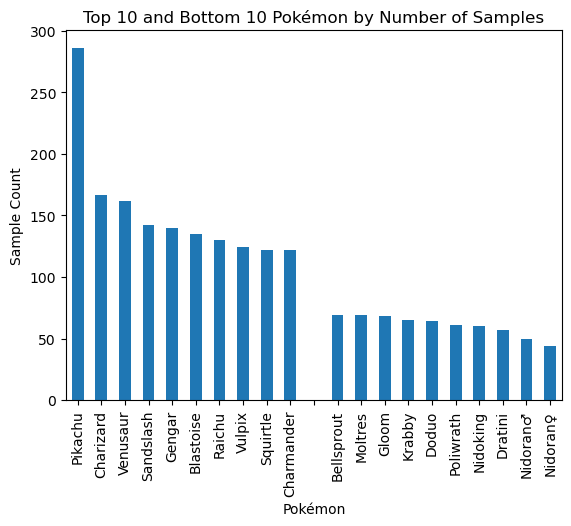

In [6]:
extreme_counts = pd.concat([counts.head(10), pd.Series([0], ['']), counts.tail(10)])
extreme_counts.plot.bar(xlabel="Pokémon", ylabel="Sample Count", title="Top 10 and Bottom 10 Pokémon by Number of Samples")
plt.show()

#### Challenging Aspects:

Our dataset presents several challenging aspects. Firstly, the images originate from various mediums, including 2D sprites from older games, 3D models from newer games, images from the Pokémon anime, Pokémon cards, fan art, etc. These varied sources introduce diverse visual styles and potential inconsistencies, adding complexity to the classification task.

Furthermore, many images retain their original backgrounds, which can introduce noise and distractions that the model needs to account for.

In addition, the same Pokémon species can have different appearances. Every Pokémon has a shiny colouring, which is a rare alternative colouring of the Pokémon. Some Pokémon also take on different forms in different regions of the Pokémon universe. Distinguishing between these variations requires the model to capture fine-grained details.

Additionally, Pokémon "evolve" into new species of Pokémon, which is akin to growing up and changing in appearance. Pokémon within the same evolutionary family can appear very similar, which presents a challenge in distinguishing between closely related species. Finally, image sizes vary significantly; for instance, game sprites tend to be quite small, often around 100 pixels by 100 pixels. The variation in image dimensions necessitates careful pre-processing to ensure consistency.


### Data Splitting for Model Evaluation

The dataset is split into training (60%), validation (20%), and testing (20%) sets to ensure the model's performance can be fairly evaluated with unseen data during training and after finalising the model.

In [7]:
random_seed = 42

# 60:20:20 train-validation-test split
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=random_seed,
    shuffle=True,
    stratify=df['class']  # Ensure all pokemon represented in each split
)
train_df, validation_df = train_test_split(
    train_df,
    test_size=0.25,
    random_state=random_seed,
    shuffle=True,
    stratify=train_df['class']
)

### Data Visualization

To visually inspect the data and confirm that images have been loaded correctly, we display a grid of images representing different Pokémon species.

In [8]:
# Display images in a grid format
def display_images(image_paths, captions, image_size, cols, figsize=(8, 8)):
    rows = (len(image_paths) + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=figsize)
    axs = axs.ravel()
    for ax in axs:
        ax.axis('off')
    for ax, image_path, caption in zip(axs, image_paths, captions):
        image = load_img(image_path, target_size=image_size)
        ax.set_title(caption)
        ax.imshow(image)

    plt.show()

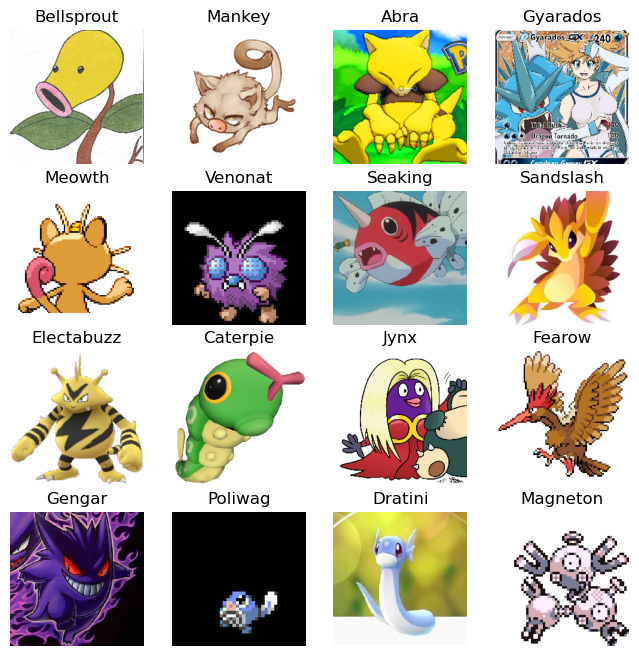

In [9]:
sample_images = train_df[:16]
display_images(sample_images['filename'], sample_images['class'], (224, 224), 4)

## Models and Training

### Overview

In this section, we will outline our training strategy, which revolves around transfer learning. Transfer learning leverages a model pre-trained on a large dataset, such as ImageNet, and adapts it to our specific task. The rationale behind this approach is to utilize the learned hierarchies of features from a model trained on a broader image domain, which can effectively generalize to our specific task with less data. This also reduces the training time required.

### Data Preprocessing

Before feeding the data into our neural network models, we implement a series of preprocessing steps to enhance its quality and suitability for training:

1. Standardized Resizing:  
All images in the dataset undergo resizing to adhere to a standardized dimension. This ensures compatibility and consistency during the training process, such that the neural network can operate on a single size of image.

2. Data Augmentation:  
Augmentation techniques are applied to introduce diversity into the dataset, enhancing the model's robustness. Transformations such as rotation, flipping, and changes in lighting conditions contribute to a more varied and representative training set.

### Utilities

We define utility functions for creating data generators, which allow us to produce batches of images that can be fed into our neural network models. These data generators can optionally apply live data augmentation techniques to improve the model's generalizability and robustness.

The `early_stopping` Keras callback is employed here so that it automatically halts the training when the validation loss stops improving for 5 epochs, while also restoring the best model weights after the process.

The `reduce_lr_on_plateau` Keras callback is used to automatically reduce the learning rate when the improvement in validation loss is reducing. This helps implement a form of learning rate scheduling that helps the model train quickly initially and slow down changes as it approaches an optimum.


In [10]:
# Makes a generator which yields mini-batches of images with optional live data augmentation
def make_image_generator(dataframe, image_size, preprocessing_function, batch_size=64, shuffle=True, **augmentations):
    datagen = ImageDataGenerator(
        preprocessing_function=preprocessing_function,
        **augmentations
    )
    return datagen.flow_from_dataframe(
        dataframe,
        target_size=image_size,
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=shuffle
    )

In [11]:
# Makes image generators using the training and validation data
def make_training_generators(image_size, preprocessing_function, batch_size=64, **augmentations):
    train_generator = make_image_generator(train_df, image_size, preprocessing_function, batch_size, **augmentations)
    validation_generator = make_image_generator(validation_df, image_size, preprocessing_function, batch_size)
    return train_generator, validation_generator

In [12]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=1,
    restore_best_weights=True
)

In [13]:
reduce_lr_on_plateau = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-5,
    verbose=1
)

### Model Selection:

Choosing the right neural network architecture is a pivotal decision in our project. Given the complexity and diversity of the Pokémon dataset, we need a model that can effectively capture intricate patterns and features within the images. To address this, we have considered several convolutional neural networks (CNNs). CNNs are renowned for their ability to handle image data and have been widely successful in image classification tasks.

Pre-trained models, such as those trained on the ImageNet dataset, come with learned feature representations that can significantly expedite the training process and potentially improve model performance. The rationale behind this selection is to capitalize on the knowledge and features learned from vast image datasets like ImageNet, which can be highly relevant in the context of Pokémon image classification.

For our specific model, we have chosen to employ a deeper existing model for transfer learning. This decision is motivated by the observation that training a complex model from scratch on our Pokémon dataset could lead to slow convergence and potential underfitting due to the limited amount of Pokémon image data. Utilizing a pre-trained deep model as a starting point allows us to benefit from its learned features and accelerate the training process, while still fine-tuning the model to adapt to the unique characteristics of Pokémon images.


#### Baseline Model: VGG16

We start with VGG16, a model known for its simplicity and deep architecture, making it a solid baseline for image classification tasks. Given its success in various visual recognition challenges, we expect it to be a good starting point for our problem.

* We use pre-trained ImageNet weights as our initial weights to speed up convergence.
* The model is adapted to our task by adding a new classification layer at the end tailored to the number of Pokémon classes.

In [14]:
# Note: preprocessing functions provided by Keras help adjust pixel values
# by centering/scaling/normalizing in the way the base model expects
train_generator, validation_generator = make_training_generators(
    image_size=(224, 224),
    preprocessing_function=vgg16.preprocess_input
)

Found 8379 validated image filenames belonging to 151 classes.
Found 2793 validated image filenames belonging to 151 classes.


In [15]:
vgg16_base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg16_base_model.trainable = False

vgg16_model = models.Sequential([
    vgg16_base_model,
    layers.Flatten(input_shape=vgg16_base_model.output_shape[1:]),
    layers.Dense(4096, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

vgg16_model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(1e-4),
    metrics=['accuracy']
)

58889256/58889256 [==============================] - 4s 0us/step


In [16]:
vgg16_history = vgg16_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[early_stopping, reduce_lr_on_plateau]
)

Epoch 1/50
131/131 [==============================] - 122s 821ms/step - loss: 10.5190 - accuracy: 0.4242 - val_loss: 4.4044 - val_accuracy: 0.6065 - lr: 1.0000e-04
Epoch 2/50
131/131 [==============================] - 95s 728ms/step - loss: 0.3230 - accuracy: 0.9595 - val_loss: 4.0320 - val_accuracy: 0.6369 - lr: 1.0000e-04
Epoch 3/50
131/131 [==============================] - 91s 694ms/step - loss: 0.1312 - accuracy: 0.9887 - val_loss: 3.7978 - val_accuracy: 0.6645 - lr: 1.0000e-04
Epoch 4/50
131/131 [==============================] - 93s 712ms/step - loss: 0.1330 - accuracy: 0.9944 - val_loss: 3.7872 - val_accuracy: 0.6674 - lr: 1.0000e-04
Epoch 5/50
131/131 [==============================] - 91s 693ms/step - loss: 0.1391 - accuracy: 0.9947 - val_loss: 3.9868 - val_accuracy: 0.6631 - lr: 1.0000e-04
Epoch 6/50
131/131 [==============================] - 90s 688ms/step - loss: 0.1701 - accuracy: 0.9967 - val_loss: 4.0575 - val_accuracy: 0.6563 - lr: 1.0000e-04
Epoch 7/50
131/131 [======

In [17]:
vgg16_model.save('models/model_baseline.tf')
with open('histories/baseline_model_training.pkl', 'wb') as file:
    pickle.dump(vgg16_history.history, file)

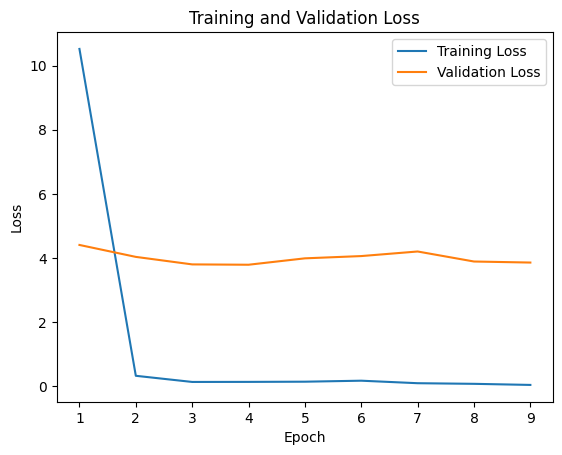

In [18]:
x_range = range(1, len(vgg16_history.history['loss']) + 1)

plt.figure()
plt.plot(x_range, vgg16_history.history['loss'], label='Training Loss')
plt.plot(x_range, vgg16_history.history['val_loss'], label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(x_range)
plt.legend()
plt.show()

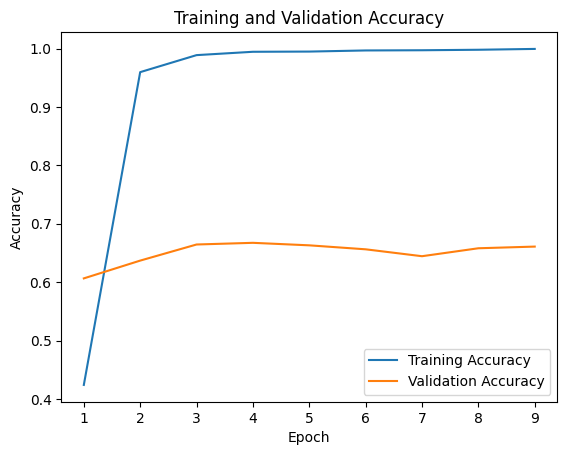

In [19]:
plt.figure()
plt.plot(x_range, vgg16_history.history['accuracy'], label='Training Accuracy')
plt.plot(x_range, vgg16_history.history['val_accuracy'], label='Validation Accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(x_range)
plt.legend()
plt.show()

### Experimenting with Various Models

After establishing the baseline with VGG16, we experiment with several other architectures:

* ResNet152: Known for its deep residual learning framework.
* InceptionV3: Utilizes inception modules to capture information at various scales.
* InceptionResNetV2: A combination of the inception architecture with residual connections.
* DenseNet201: Features densely connected convolutional networks.
* EfficientNetB7: Uses a compound scaling method for uniform scaling of depth, width, and resolution.

Each architecture's performance is evaluated by training for 10 epochs. Our findings suggest that DenseNet201 performs the best in terms of validation loss and validation accuracy. DenseNet201 also appears to train faster than the other models, which is useful for trying out more ideas quickly. Hence, we decided to choose DenseNet201 as our base model for transfer learning.

In [20]:
train_generator, validation_generator = make_training_generators(
    image_size=(224, 224),
    preprocessing_function=resnet.preprocess_input
)

resnet_base_model = ResNet152(weights='imagenet', include_top=False)
resnet_base_model.trainable = False

resnet_model = models.Sequential([
    resnet_base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(num_classes, activation='softmax')
])

resnet_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

Found 8379 validated image filenames belonging to 151 classes.
Found 2793 validated image filenames belonging to 151 classes.
234698864/234698864 [==============================] - 7s 0us/step


In [21]:
resnet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping]
)

Epoch 1/10
131/131 [==============================] - 124s 841ms/step - loss: 2.9245 - accuracy: 0.4052 - val_loss: 1.5775 - val_accuracy: 0.6466
Epoch 2/10
131/131 [==============================] - 108s 824ms/step - loss: 0.8536 - accuracy: 0.8160 - val_loss: 1.2093 - val_accuracy: 0.7161
Epoch 3/10
131/131 [==============================] - 105s 800ms/step - loss: 0.4525 - accuracy: 0.9203 - val_loss: 1.0070 - val_accuracy: 0.7633
Epoch 4/10
131/131 [==============================] - 122s 928ms/step - loss: 0.2732 - accuracy: 0.9622 - val_loss: 0.9331 - val_accuracy: 0.7820
Epoch 5/10
131/131 [==============================] - 104s 793ms/step - loss: 0.1752 - accuracy: 0.9851 - val_loss: 0.8932 - val_accuracy: 0.7863
Epoch 6/10
131/131 [==============================] - 107s 814ms/step - loss: 0.1209 - accuracy: 0.9912 - val_loss: 0.8762 - val_accuracy: 0.7916
Epoch 7/10
131/131 [==============================] - 121s 924ms/step - loss: 0.0875 - accuracy: 0.9947 - val_loss: 0.8597 -

In [22]:
train_generator, validation_generator = make_training_generators(
    image_size=(299, 299),
    preprocessing_function=inception_v3.preprocess_input
)

inception_v3_base_model = InceptionV3(weights='imagenet', include_top=False)
inception_v3_base_model.trainable = False

inception_v3_model = models.Sequential([
    inception_v3_base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(num_classes, activation='softmax')
])

inception_v3_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

Found 8379 validated image filenames belonging to 151 classes.
Found 2793 validated image filenames belonging to 151 classes.
87910968/87910968 [==============================] - 3s 0us/step


In [23]:
inception_v3_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping]
)

Epoch 1/10
131/131 [==============================] - 130s 921ms/step - loss: 4.1180 - accuracy: 0.1839 - val_loss: 3.1827 - val_accuracy: 0.3974
Epoch 2/10
131/131 [==============================] - 103s 786ms/step - loss: 2.3841 - accuracy: 0.5435 - val_loss: 2.3950 - val_accuracy: 0.5066
Epoch 3/10
131/131 [==============================] - 116s 884ms/step - loss: 1.6560 - accuracy: 0.6958 - val_loss: 2.0930 - val_accuracy: 0.5550
Epoch 4/10
131/131 [==============================] - 116s 884ms/step - loss: 1.2562 - accuracy: 0.7772 - val_loss: 1.8617 - val_accuracy: 0.6019
Epoch 5/10
131/131 [==============================] - 118s 900ms/step - loss: 0.9921 - accuracy: 0.8351 - val_loss: 1.7107 - val_accuracy: 0.6226
Epoch 6/10
131/131 [==============================] - 104s 789ms/step - loss: 0.8081 - accuracy: 0.8730 - val_loss: 1.6618 - val_accuracy: 0.6276
Epoch 7/10
131/131 [==============================] - 102s 777ms/step - loss: 0.6661 - accuracy: 0.9064 - val_loss: 1.5759 -

In [24]:
train_generator, validation_generator = make_training_generators(
    image_size=(299, 299),
    preprocessing_function=inception_resnet_v2.preprocess_input
)

inception_resnet_base_model = InceptionResNetV2(weights='imagenet', include_top=False)
inception_resnet_base_model.trainable = False

inception_resnet_model = models.Sequential([
    inception_resnet_base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(num_classes, activation='softmax')
])

inception_resnet_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

Found 8379 validated image filenames belonging to 151 classes.
Found 2793 validated image filenames belonging to 151 classes.
219055592/219055592 [==============================] - 7s 0us/step


In [25]:
inception_resnet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping]
)

Epoch 1/10
131/131 [==============================] - 142s 972ms/step - loss: 4.2584 - accuracy: 0.1621 - val_loss: 3.3941 - val_accuracy: 0.3358
Epoch 2/10
131/131 [==============================] - 128s 978ms/step - loss: 2.7460 - accuracy: 0.4614 - val_loss: 2.6472 - val_accuracy: 0.4637
Epoch 3/10
131/131 [==============================] - 119s 906ms/step - loss: 2.0701 - accuracy: 0.6094 - val_loss: 2.2535 - val_accuracy: 0.5353
Epoch 4/10
131/131 [==============================] - 137s 1s/step - loss: 1.6751 - accuracy: 0.6870 - val_loss: 2.0193 - val_accuracy: 0.5782
Epoch 5/10
131/131 [==============================] - 128s 972ms/step - loss: 1.4158 - accuracy: 0.7430 - val_loss: 1.8748 - val_accuracy: 0.6087
Epoch 6/10
131/131 [==============================] - 116s 882ms/step - loss: 1.2294 - accuracy: 0.7797 - val_loss: 1.7541 - val_accuracy: 0.6305
Epoch 7/10
131/131 [==============================] - 114s 871ms/step - loss: 1.0764 - accuracy: 0.8130 - val_loss: 1.6976 - va

In [26]:
train_generator, validation_generator = make_training_generators(
    image_size=(224, 224),
    preprocessing_function=densenet.preprocess_input
)

densenet_base_model = DenseNet201(weights='imagenet', include_top=False)
densenet_base_model.trainable = False

densenet_model = models.Sequential([
    densenet_base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(num_classes, activation='softmax')
])

densenet_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

Found 8379 validated image filenames belonging to 151 classes.
Found 2793 validated image filenames belonging to 151 classes.
74836368/74836368 [==============================] - 3s 0us/step


In [27]:
densenet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping]
)

Epoch 1/10
131/131 [==============================] - 152s 984ms/step - loss: 3.7086 - accuracy: 0.2825 - val_loss: 2.4595 - val_accuracy: 0.5424
Epoch 2/10
131/131 [==============================] - 96s 734ms/step - loss: 1.6154 - accuracy: 0.7427 - val_loss: 1.5976 - val_accuracy: 0.7014
Epoch 3/10
131/131 [==============================] - 98s 749ms/step - loss: 0.9692 - accuracy: 0.8531 - val_loss: 1.2716 - val_accuracy: 0.7537
Epoch 4/10
131/131 [==============================] - 96s 734ms/step - loss: 0.6648 - accuracy: 0.9101 - val_loss: 1.1127 - val_accuracy: 0.7723
Epoch 5/10
131/131 [==============================] - 96s 733ms/step - loss: 0.4897 - accuracy: 0.9419 - val_loss: 1.0093 - val_accuracy: 0.7880
Epoch 6/10
131/131 [==============================] - 94s 713ms/step - loss: 0.3771 - accuracy: 0.9603 - val_loss: 0.9414 - val_accuracy: 0.8042
Epoch 7/10
131/131 [==============================] - 97s 743ms/step - loss: 0.2927 - accuracy: 0.9743 - val_loss: 0.8893 - val_a

In [28]:
train_generator, validation_generator = make_training_generators(
    image_size=(224, 224),
    preprocessing_function=efficientnet.preprocess_input
)

efficientnet_base_model = EfficientNetB7(weights='imagenet', include_top=False)
efficientnet_base_model.trainable = False

efficientnet_model = models.Sequential([
    efficientnet_base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(num_classes, activation='softmax')
])

efficientnet_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

Found 8379 validated image filenames belonging to 151 classes.
Found 2793 validated image filenames belonging to 151 classes.
258076736/258076736 [==============================] - 8s 0us/step


In [29]:
efficientnet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping]
)

Epoch 1/10
131/131 [==============================] - 167s 1s/step - loss: 3.2568 - accuracy: 0.4152 - val_loss: 2.0174 - val_accuracy: 0.6724
Epoch 2/10
131/131 [==============================] - 125s 952ms/step - loss: 1.4817 - accuracy: 0.7606 - val_loss: 1.3981 - val_accuracy: 0.7504
Epoch 3/10
131/131 [==============================] - 124s 948ms/step - loss: 0.9914 - accuracy: 0.8379 - val_loss: 1.1662 - val_accuracy: 0.7726
Epoch 4/10
131/131 [==============================] - 125s 952ms/step - loss: 0.7348 - accuracy: 0.8850 - val_loss: 1.0444 - val_accuracy: 0.7863
Epoch 5/10
131/131 [==============================] - 134s 1s/step - loss: 0.5800 - accuracy: 0.9160 - val_loss: 0.9666 - val_accuracy: 0.8038
Epoch 6/10
131/131 [==============================] - 124s 944ms/step - loss: 0.4762 - accuracy: 0.9327 - val_loss: 0.9199 - val_accuracy: 0.8059
Epoch 7/10
131/131 [==============================] - 135s 1s/step - loss: 0.3931 - accuracy: 0.9493 - val_loss: 0.8896 - val_accu

## Data Augmentation


#### What is Data Augmentation?

Data augmentation is a technique used to increase the diversity of data available for training models without actually collecting new data. This is achieved by applying random but realistic transformations to the training images, such as rotation, scaling, and horizontal flipping. The purpose is to simulate the variability that a model will encounter in the real world, thus improving its ability to generalize from the training data to unseen data.

#### Why Use Data Augmentation?

In our Pokémon species identification project, data augmentation serves multiple purposes:

* Increase dataset size: Since our dataset is relatively limited in size, augmentation can help artificially create more samples to train on.
* Combat Overfitting: With a relatively small dataset, our model is at risk of memorizing the training data rather than learning general patterns. Augmentation helps prevent overfitting by providing a more robust set of training examples.
* Real-World Variability: Pokémon images may come in various styles and contexts. Augmentation introduces our model to the kinds of variations it might encounter in practical scenarios.

#### Choosing Augmentations

The augmentations were chosen based on domain knowledge on what makes a valid image of a Pokémon:

* rotation_range=20: Pokémon can be seen from different angles.
* width_shift_range=0.1, height_shift_range=0.1: Pokémon may not always be centered in the image.
* brightness_range=(0.8, 1.2): Images can have different lighting conditions.
* zoom_range=0.2: The scale of Pokémon can vary in different images.
* horizontal_flip=True: Some Pokémon species may appear facing either direction.
* fill_mode='nearest': Ensures that rotating or shifting images does not introduce empty pixels.

In [30]:
def make_augmented_dataset():
    return make_training_generators(
        image_size=(224, 224),
        preprocessing_function=densenet.preprocess_input,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        brightness_range=(0.8, 1.2),
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

We trained a DenseNet201 model using non-augmented and augmented data to compare their performances.

In [31]:
# Without data augmentations
train_generator, validation_generator = make_training_generators(
    image_size=(224, 224),
    preprocessing_function=densenet.preprocess_input
)

densenet_base_model = DenseNet201(weights='imagenet', include_top=False)
densenet_base_model.trainable = False

densenet_model = models.Sequential([
    densenet_base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(num_classes, activation='softmax')
])

densenet_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

Found 8379 validated image filenames belonging to 151 classes.
Found 2793 validated image filenames belonging to 151 classes.


In [32]:
hist1 = densenet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[early_stopping]
)

Epoch 1/20
131/131 [==============================] - 143s 905ms/step - loss: 3.7243 - accuracy: 0.2733 - val_loss: 2.4134 - val_accuracy: 0.5521
Epoch 2/20
131/131 [==============================] - 100s 767ms/step - loss: 1.6296 - accuracy: 0.7310 - val_loss: 1.5424 - val_accuracy: 0.7182
Epoch 3/20
131/131 [==============================] - 97s 738ms/step - loss: 0.9817 - accuracy: 0.8515 - val_loss: 1.2304 - val_accuracy: 0.7526
Epoch 4/20
131/131 [==============================] - 113s 861ms/step - loss: 0.6755 - accuracy: 0.9089 - val_loss: 1.0732 - val_accuracy: 0.7834
Epoch 5/20
131/131 [==============================] - 95s 721ms/step - loss: 0.4989 - accuracy: 0.9404 - val_loss: 0.9815 - val_accuracy: 0.7898
Epoch 6/20
131/131 [==============================] - 100s 764ms/step - loss: 0.3788 - accuracy: 0.9588 - val_loss: 0.9035 - val_accuracy: 0.8088
Epoch 7/20
131/131 [==============================] - 99s 754ms/step - loss: 0.2954 - accuracy: 0.9745 - val_loss: 0.8649 - va

In [33]:
with open('histories/training_no_augmentation.pkl', 'wb') as file:
    pickle.dump(hist1.history, file)

In [34]:
# With live data augmentations
train_generator, validation_generator = make_augmented_dataset()

densenet_base_model = DenseNet201(weights='imagenet', include_top=False)
densenet_base_model.trainable = False

densenet_model = models.Sequential([
    densenet_base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(num_classes, activation='softmax')
])

densenet_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

Found 8379 validated image filenames belonging to 151 classes.
Found 2793 validated image filenames belonging to 151 classes.


In [35]:
hist2 = densenet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[early_stopping]
)

Epoch 1/20
131/131 [==============================] - 240s 2s/step - loss: 3.9311 - accuracy: 0.2275 - val_loss: 2.6041 - val_accuracy: 0.5109
Epoch 2/20
131/131 [==============================] - 219s 2s/step - loss: 2.0228 - accuracy: 0.6287 - val_loss: 1.7165 - val_accuracy: 0.6667
Epoch 3/20
131/131 [==============================] - 225s 2s/step - loss: 1.3439 - accuracy: 0.7605 - val_loss: 1.3493 - val_accuracy: 0.7322
Epoch 4/20
131/131 [==============================] - 221s 2s/step - loss: 1.0217 - accuracy: 0.8153 - val_loss: 1.1556 - val_accuracy: 0.7587
Epoch 5/20
131/131 [==============================] - 220s 2s/step - loss: 0.8126 - accuracy: 0.8563 - val_loss: 1.0545 - val_accuracy: 0.7673
Epoch 6/20
131/131 [==============================] - 223s 2s/step - loss: 0.6865 - accuracy: 0.8773 - val_loss: 0.9736 - val_accuracy: 0.7798
Epoch 7/20
131/131 [==============================] - 220s 2s/step - loss: 0.5897 - accuracy: 0.8975 - val_loss: 0.9278 - val_accuracy: 0.7891

In [36]:
with open('histories/training_with_augmentation.pkl', 'wb') as file:
    pickle.dump(hist2.history, file)

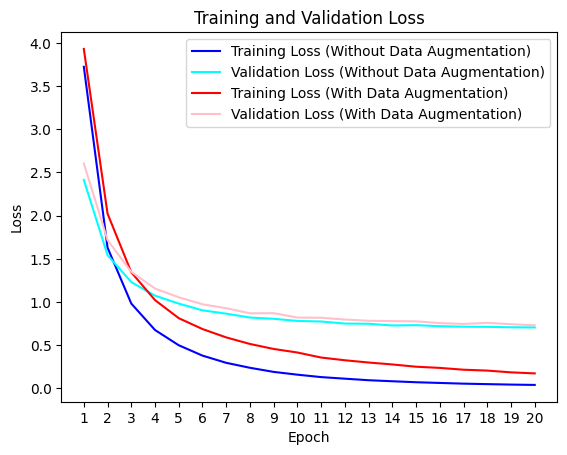

In [37]:
x_range = range(1, 21)

plt.figure()
plt.plot(x_range, hist1.history['loss'], label='Training Loss (Without Data Augmentation)', color='blue')
plt.plot(x_range, hist1.history['val_loss'], label='Validation Loss (Without Data Augmentation)', color='cyan')
plt.plot(x_range, hist2.history['loss'], label='Training Loss (With Data Augmentation)', color='red')
plt.plot(x_range, hist2.history['val_loss'], label='Validation Loss (With Data Augmentation)', color='pink')

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(x_range)
plt.legend()
plt.show()

Both models achieved a similar validation loss at the end of 20 epochs. However, When trained without augmentation, the model showed greater signs of overfitting, with training accuracy much higher than validation accuracy. With augmentation, both accuracies were closer, suggesting that the model was learning features that were more general and overfitting less.

We also observed that augmenting the data causes the model to learn more slowly, requiring more epochs to reach the same validation loss. This is likely because the model is now being forced to identify more general features which are more difficult to learn. This slow down in training is worthwhile to combat overfitting.

## Hyperparameter Tuning for Classification Head

To further refine our model, we experiment with the hyperparameters of the classification head added to DenseNet201, such as the number of dense layers added and dropout rates.

### Overview

The classification head of a neural network is pivotal for tailoring the model's predictions to the specific task—in our case, Pokémon species identification. To optimize this component, we engage in hyperparameter tuning, exploring different configurations to improve performance. Here, we detail the process and outcomes of this search.

### Building the Model

We start by constructing a model with the DenseNet201 architecture. The classification head is then defined, varying hyperparameters such as dropout rate and the number of dense layers selected for tuning.

In [38]:
train_generator, validation_generator = make_augmented_dataset()
densenet_base_model = DenseNet201(weights='imagenet', include_top=False)
densenet_base_model.trainable = False

In [39]:
def build_model(hp):
    dropout = hp.Choice('dropout', values=[0.0, 0.25, 0.5])
    model = models.Sequential()
    model.add(densenet_base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(dropout))
    for i in range(hp.Int('num_layers', 0, 2)):
        model.add(layers.Dense(1024 // (2 ** i), activation='relu'))
        model.add(layers.Dropout(dropout))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer="adam",
        loss='categorical_crossentropy',
        metrics=['accuracy'],
    )

    return model

### Hyperparameter Search

Using the Keras Tuner library, we perform a grid search to find the optimal combination of dropout rate and the number of dense layers. We use validation accuracy as our objective metric to guide the search.

In [40]:
tuner = kt.tuners.GridSearch(
    build_model,
    objective='val_accuracy',
    directory='tuner',
    project_name='pokedex'
)

tuner.search_space_summary()

Search space summary
Default search space size: 2
dropout (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.25, 0.5], 'ordered': True}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 2, 'step': 1, 'sampling': 'linear'}


### Results of Hyperparameter Tuning

After a series of trials, we identify the best hyperparameters. A dropout rate of 0.25 and no additional dense layers (besides the classification layer) yield the highest validation accuracy.

In [41]:
tuner.search(
    train_generator,
    validation_data=validation_generator,
    epochs=15,
    callbacks=[early_stopping]
)

tuner.results_summary()

Results summary
Results in /tuner/pokedex
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0003 summary
Hyperparameters:
dropout: 0.25
num_layers: 0
Score: 0.8148943781852722

Trial 0000 summary
Hyperparameters:
dropout: 0.0
num_layers: 0
Score: 0.8088077306747437

Trial 0006 summary
Hyperparameters:
dropout: 0.5
num_layers: 0
Score: 0.7973505258560181

Trial 0004 summary
Hyperparameters:
dropout: 0.25
num_layers: 1
Score: 0.795918345451355

Trial 0001 summary
Hyperparameters:
dropout: 0.0
num_layers: 1
Score: 0.7780164480209351

Trial 0005 summary
Hyperparameters:
dropout: 0.25
num_layers: 2
Score: 0.7629788517951965

Trial 0007 summary
Hyperparameters:
dropout: 0.5
num_layers: 1
Score: 0.7608306407928467

Trial 0002 summary
Hyperparameters:
dropout: 0.0
num_layers: 2
Score: 0.7601145505905151

Trial 0008 summary
Hyperparameters:
dropout: 0.5
num_layers: 2
Score: 0.6595059037208557


### Training and Fine-tuning Final Model

#### Transfer Learning and Fine-tuning

We employ transfer learning with the DenseNet201 architecture, initializing it with ImageNet weights. Training is first done on the classification head alone to allow the model time to gradually adapt to the new task. We then proceed to fine-tune the model by unfreezing the top layers of the base model for additional training. Doing the training in stages helps ensure that large gradients at the start of training do not destroy the pretrained features of the base model.

#### Initial Training

The model is first trained with the base layers frozen to allow the newly added classification head to learn from the features extracted by DenseNet201.

In [42]:
train_generator, validation_generator = make_augmented_dataset()

densenet_base_model = DenseNet201(weights='imagenet', include_top=False)
densenet_base_model.trainable = False
inputs = Input(shape=(224, 224, 3))
x = densenet_base_model(inputs, training=False)  # Ensure batchnorm layers run in inference mode
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history_train = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[early_stopping, reduce_lr_on_plateau]
)

Found 8379 validated image filenames belonging to 151 classes.
Found 2793 validated image filenames belonging to 151 classes.
Epoch 1/50
131/131 [==============================] - 224s 2s/step - loss: 4.2140 - accuracy: 0.1563 - val_loss: 2.8107 - val_accuracy: 0.4612 - lr: 0.0010
Epoch 2/50
131/131 [==============================] - 204s 2s/step - loss: 2.3686 - accuracy: 0.5189 - val_loss: 1.8548 - val_accuracy: 0.6480 - lr: 0.0010
Epoch 3/50
131/131 [==============================] - 223s 2s/step - loss: 1.6577 - accuracy: 0.6613 - val_loss: 1.4528 - val_accuracy: 0.7111 - lr: 0.0010
Epoch 4/50
131/131 [==============================] - 215s 2s/step - loss: 1.3253 - accuracy: 0.7244 - val_loss: 1.2665 - val_accuracy: 0.7354 - lr: 0.0010
Epoch 5/50
131/131 [==============================] - 213s 2s/step - loss: 1.1012 - accuracy: 0.7673 - val_loss: 1.1311 - val_accuracy: 0.7540 - lr: 0.0010
Epoch 6/50
131/131 [==============================] - 201s 2s/step - loss: 0.9642 - accuracy: 

In [43]:
model.save('models/model_untuned.tf')
with open('histories/final_model_training.pkl', 'wb') as file:
    pickle.dump(history_train.history, file)

#### Fine-tuning

After the initial training phase, we unfreeze the top layers of the DenseNet201 model and continue training. This step is crucial as it allows the higher-level features of the model to adjust more closely to the Pokémon dataset.

In [44]:
NUM_LAYERS_TO_UNFREEZE = 100

for layer in densenet_base_model.layers[-NUM_LAYERS_TO_UNFREEZE:]:
    layer.trainable = True

model.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(1e-4),
    metrics=['accuracy']
)

history_tune = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    callbacks=[early_stopping, reduce_lr_on_plateau]
)

Epoch 1/30
131/131 [==============================] - 213s 2s/step - loss: 0.2530 - accuracy: 0.9391 - val_loss: 0.6878 - val_accuracy: 0.8346 - lr: 1.0000e-04
Epoch 2/30
131/131 [==============================] - 198s 2s/step - loss: 0.2619 - accuracy: 0.9322 - val_loss: 0.6839 - val_accuracy: 0.8360 - lr: 1.0000e-04
Epoch 3/30
131/131 [==============================] - 194s 1s/step - loss: 0.2590 - accuracy: 0.9352 - val_loss: 0.6846 - val_accuracy: 0.8328 - lr: 1.0000e-04
Epoch 4/30
131/131 [==============================] - 196s 1s/step - loss: 0.2689 - accuracy: 0.9333 - val_loss: 0.6817 - val_accuracy: 0.8346 - lr: 1.0000e-04
Epoch 5/30
131/131 [==============================] - 198s 2s/step - loss: 0.2674 - accuracy: 0.9316 - val_loss: 0.6811 - val_accuracy: 0.8353 - lr: 1.0000e-04
Epoch 6/30
131/131 [==============================] - 194s 1s/step - loss: 0.2675 - accuracy: 0.9344 - val_loss: 0.6819 - val_accuracy: 0.8357 - lr: 1.0000e-04
Epoch 7/30
131/131 [====================

In [45]:
model.save('models/model_final.tf')
with open('histories/final_model_tuning.pkl', 'wb') as file:
    pickle.dump(history_tune.history, file)

### Evaluation

To evaluate the model's learning process, we plot the training and validation loss and accuracy over epochs.

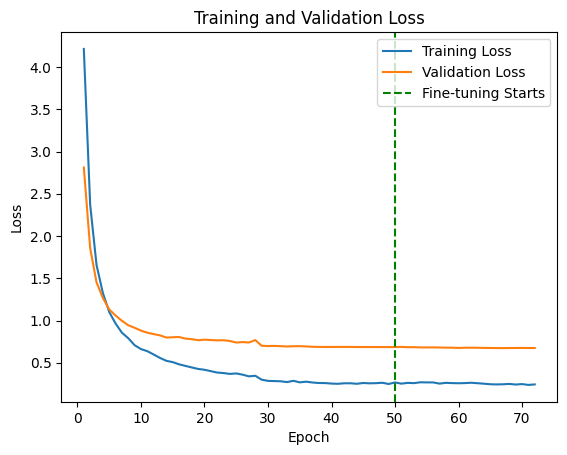

In [46]:
loss_history = history_train.history['loss'] + history_tune.history['loss']
val_loss_history = history_train.history['val_loss'] + history_tune.history['val_loss']

num_train_epochs = len(history_train.history['loss'])
x_range = range(1, len(loss_history) + 1)

plt.figure()
plt.plot(x_range, loss_history, label='Training Loss')
plt.plot(x_range, val_loss_history, label='Validation Loss')
plt.axvline(num_train_epochs, label='Fine-tuning Starts', color='green', linestyle='--')

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

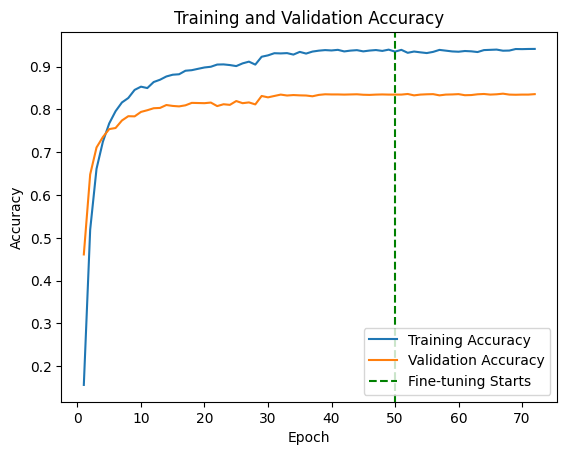

In [47]:
acc_history = history_train.history['accuracy'] + history_tune.history['accuracy']
val_acc_history = history_train.history['val_accuracy'] + history_tune.history['val_accuracy']

plt.figure()
plt.plot(x_range, acc_history, label='Training Accuracy')
plt.plot(x_range, val_acc_history, label='Validation Accuracy')
plt.axvline(num_train_epochs, label='Fine-tuning Starts', color='green', linestyle='--')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Analysis of Results

In this section, we evaluate and compare the performance of our baseline model, VGG16, with our final tuned model using DenseNet201.

In [48]:
baseline_model = models.load_model('models/model_baseline.tf')
final_model = models.load_model('models/model_final.tf')

In [49]:
baseline_model_test_generator = make_image_generator(
    test_df,
    image_size=(224, 224),
    preprocessing_function=vgg16.preprocess_input,
    shuffle=False
)
final_model_test_generator = make_image_generator(
    test_df,
    image_size=(224, 224),
    preprocessing_function=densenet.preprocess_input,
    shuffle=False
)

Found 2793 validated image filenames belonging to 151 classes.
Found 2793 validated image filenames belonging to 151 classes.


### Model Performance Metrics

Upon evaluation, the baseline model achieved an accuracy of 63.66% on the test set, while the final model showed a significant improvement with an accuracy of 83.96%. Not only does the final model outperform the baseline in accuracy, but it also achieves better loss metrics, indicating a more reliable performance.

In [50]:
baseline_model_loss, baseline_model_acc = baseline_model.evaluate(baseline_model_test_generator)
final_model_loss, final_model_acc = final_model.evaluate(final_model_test_generator)

print(f'Baseline model loss: {baseline_model_loss:.5f}, Baseline model accuracy: {baseline_model_acc:.3%}')
print(f'Final model loss: {final_model_loss:.5f}, Final model accuracy: {final_model_acc:.3%}')

44/44 [==============================] - 36s 565ms/step - loss: 0.6441 - accuracy: 0.8396
Baseline model loss: 3.99398, Baseline model accuracy: 63.659%
Final model loss: 0.64408, Final model accuracy: 83.960%


#### Top-K Accuracy

Top-5 accuracy, which allows for the correct label to be within the top five predictions, was 79.81% for the baseline and 94.42% for the final model. This again shows that our final model outperforms the baseline model in correctly identifying Pokémon.

In [51]:
baseline_model_probs = baseline_model.predict(baseline_model_test_generator)
final_model_probs = final_model.predict(final_model_test_generator)
actual_labels = final_model_test_generator.classes

k = 5
baseline_model_k_acc = top_k_accuracy_score(actual_labels, baseline_model_probs, k=k)
final_model_k_acc = top_k_accuracy_score(actual_labels, final_model_probs, k=k)

print(f'Baseline model top-{k} accuracy: {baseline_model_k_acc:.3%}')
print(f'Final model top-{k} accuracy: {final_model_k_acc:.3%}')

44/44 [==============================] - 36s 722ms/step
Baseline model top-5 accuracy: 79.807%
Final model top-5 accuracy: 94.415%


### Weighted Average F1 Score

We calculated the weighted average F1 score to account for class imbalance. The final model's weighted average F1 score is 0.8392, compared to the baseline's 0.6388, highlighting the final model's better balance between precision and recall across all classes.

In [52]:
baseline_pred_labels = np.argmax(baseline_model_probs, axis=-1)
final_pred_labels = np.argmax(final_model_probs, axis=-1)

# Use weighted average to account for class imbalance
baseline_model_f1 = f1_score(actual_labels, baseline_pred_labels, average='weighted')
final_model_f1 = f1_score(actual_labels, final_pred_labels, average='weighted')

print(f'Baseline model weighted average f1 score: {baseline_model_f1:.5f}')
print(f'Final model weighted average f1 score: {final_model_f1:.5f}')

Baseline model weighted average f1 score: 0.63876
Final model weighted average f1 score: 0.83919


### Classification Report

The classification report provides a detailed view of our final model's performance across individual classes, showing precision, recall, and F1-score. The vast majority of classes appear to be classified fairly accurately.

In [53]:
print(classification_report(actual_labels, final_pred_labels, target_names=class_names))

              precision    recall  f1-score   support

        Abra       1.00      0.93      0.96        14
  Aerodactyl       0.72      0.90      0.80        20
    Alakazam       0.81      0.94      0.87        18
       Arbok       0.94      0.83      0.88        18
    Arcanine       0.85      0.89      0.87        19
    Articuno       1.00      0.95      0.97        19
    Beedrill       0.94      0.83      0.88        18
  Bellsprout       1.00      0.86      0.92        14
   Blastoise       0.93      0.93      0.93        27
   Bulbasaur       0.81      0.91      0.86        23
  Butterfree       0.96      1.00      0.98        22
    Caterpie       1.00      0.72      0.84        18
     Chansey       0.89      0.84      0.86        19
   Charizard       0.72      0.85      0.78        33
  Charmander       0.82      0.96      0.88        24
  Charmeleon       0.79      0.71      0.75        21
    Clefable       1.00      0.61      0.76        18
    Clefairy       0.85    

### Confusion Matrix

Creating a confusion matrix for the results, we see that most of the classifications fall onto the main diagonal, showing that most classifications are done correctly.

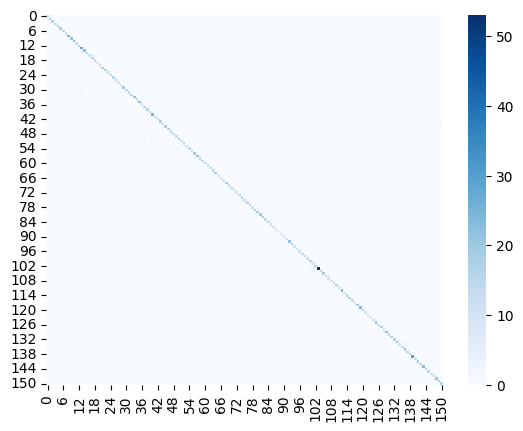

In [54]:
conf_matrix = confusion_matrix(actual_labels, final_pred_labels)
sns.heatmap(conf_matrix, cmap='Blues')
plt.show()

### Misclassification Analysis

We studied the values in the confusion matrix more closely to see which Pokémon tend to be misclassified as which other Pokémon. We found that Pokémon within the same evolutionary family tend to be confused for each other, such as Polywhirl and Poliwrath, likely due to their evolutionary relationship and visual similarities. We also found that Pokémon sharing similar colours tended to be misclassified as each other, such as Weedle and Psyduck.

In [55]:
most_common_misclassifications = []

for r, row in enumerate(conf_matrix):
    for c, val in enumerate(row):
        if r != c and val > 0:
            most_common_misclassifications.append((val, r, c))

most_common_misclassifications.sort(reverse=True)

print("Top Misclassifications:")
for count, actual, pred in most_common_misclassifications[:20]:
    print(f"True class {class_names[actual]} misclassified as {class_names[pred]}: Count {count}")

Top Misclassifications:
True class Poliwhirl misclassified as Poliwrath: Count 4
True class Voltorb misclassified as Electrode: Count 3
True class Seel misclassified as Wartortle: Count 3
True class Pidgeotto misclassified as Pidgey: Count 3
True class Pidgeotto misclassified as Pidgeot: Count 3
True class Pidgeot misclassified as Pidgeotto: Count 3
True class Nidorino misclassified as Nidoran♂: Count 3
True class Nidoran♀ misclassified as Nidorina: Count 3
True class Muk misclassified as Grimer: Count 3
True class Magneton misclassified as Magnemite: Count 3
True class Kadabra misclassified as Alakazam: Count 3
True class Haunter misclassified as Gengar: Count 3
True class Cubone misclassified as Marowak: Count 3
True class Clefable misclassified as Clefairy: Count 3
True class Weedle misclassified as Psyduck: Count 2
True class Wartortle misclassified as Squirtle: Count 2
True class Rattata misclassified as Nidoking: Count 2
True class Rattata misclassified as Aerodactyl: Count 2
Tru

### Visual Examples of Misclassifications

We also present visual examples of misclassified images. These instances provide insights into the types of errors the model is prone to making, offering guidance for potential data augmentation or additional training strategies to improve model performance. For example, the misclassification of a Charmeleon as Raichu could be attributed to the resemblance in their appearance and color (orange, bipedal and with a tail).

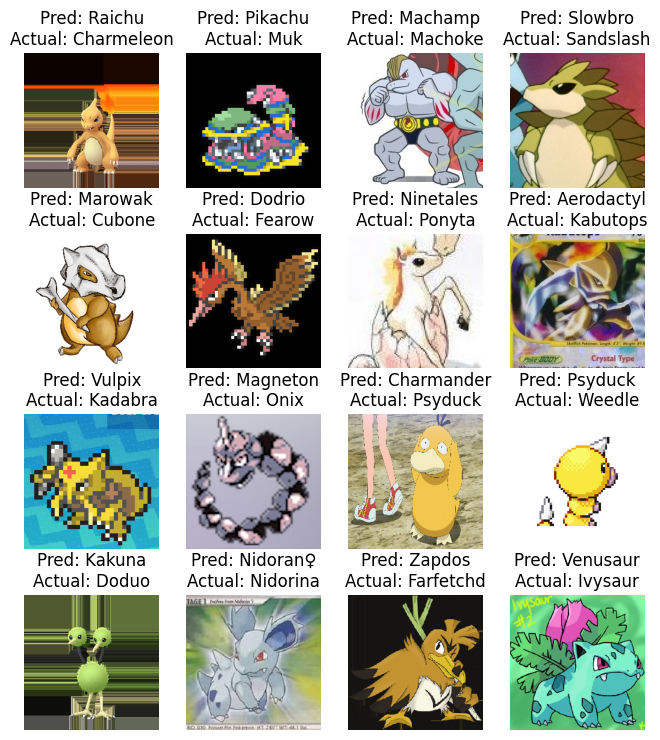

In [56]:
misclassified_image_idxs = [idx for idx, (pred, actual) in enumerate(zip(final_pred_labels, actual_labels)) if pred != actual]
misclassified_images = test_df.iloc[misclassified_image_idxs]
captions = [
    f'Pred: {class_names[final_pred_labels[idx]]}\nActual: {class_names[actual_labels[idx]]}'
    for idx in misclassified_image_idxs
]
display_images(misclassified_images['filename'][:16], captions[:16], (224, 224), 4, figsize=(8, 9))

## Discussion

Our model's results are promising and show that the classificaiton task has been performed successfully. However, there are areas for improvement and new avenues to explore. We use a SWOT analysis to give us a clear picture of where we stand and where we can go from here.

### Strengths

The project's strengths are evident in its high accuracy rates and rare misclassifications. The use of transfer learning with DenseNet201 has proven to be effective, with the model demonstrating the capability to accurately classify Pokémon images across various classes as well as from different media. Moreover, mistakes that do occur are often understandable, such as confusion between Pokémon within the same evolutionary line, which reflects challenges people would face classifying Pokémon images themselves.

### Weaknesses

Despite the high accuracy, the project does exhibit some weaknesses:

* Resource Intensity: The models, particularly the more complex architectures like DenseNet201 and EfficientNetB7, require significant memory for storage and computational power for processing, which can limit their scalability and accessibility.
* Overfitting Tendencies: There is evidence of overfitting, as indicated by the validation loss being much higher than the training loss. This suggests that the model may be learning some noise or details specific to the training set that do not generalize well.
* Our model faces difficulty classifying some instances when they look too similar, as is the case when the Pokémon are form the same family or when they share similar colour schemes.

### Limitations (Threats)

Several limitations were encountered during the project:

* Dataset Size: Our dataset is limited in size and in the variety of the samples. A larger and more diverse dataset would be beneficial, especially one that includes more varied examples of the different forms of Pokémon and from different media, to further improve the model's robustness and generalizability.
* Computing Resources: Limited computing power restricts the extent of experimentation with model architectures and hyperparameters we could do, potentially leading to suboptimal solutions.

### Opportunities for Future Work

The project presents several opportunities for future development:

* Architectural Exploration: There is scope for experimenting with additional neural network architectures to find more efficient or accurate models.
* Hyperparameter Expansion: Extending the range and types of hyperparameters tested, such as learning rates and batch sizes, could yield performance improvements.
* Layer-wise Unfreezing: Incremental unfreezing of layers during fine-tuning may offer a more nuanced approach to transfer learning, allowing the model to adapt more precisely to the task.
* Color Augmentation: Introducing more drastic color changes, like grayscale augmentation, could help the model focus less on color and more on structural features of the Pokémon.
* Dataset Expansion: Extending the dataset to include more generations of Pokémon, up to the latest Generation 9, would significantly increase the number of classes (~1000) but improve the model's applicability to a broader range of species.

## Conclusion

In summing up this endeavour, we embarked on a journey to develop a tool that could navigate the intricate world of Pokémon, and the results have been impressive. Our project began with a clear challenge: to identify Pokémon species from images, a task that many fans might find entertaining and useful. We chose a powerful neural network, DenseNet201, and fine-tuned it  to our task, honing its ability to distinguish between a wide array of creatures.

The process was thorough: from carefully collecting and examining data to making strategic choices about the machine learning models we employed. The effort paid off, with the final model achieving a high level of accuracy, demonstrating not just a technical win but a meaningful advancement in how we interact with and enjoy the Pokémon experience.

Despite intense computation demands and various failed models we tried, we learnt valuable lessons that have set a clear direction for future enhancements. This project has room for future work, with potential expansions in dataset diversity and further explorations of model capabilities.

This project is a testament to the possibilities at the intersection of technology and passion. It is a reminder that with the right tools and determination, we can create solutions that are both sophisticated and accessible to a wide audience. The path forward is ripe with opportunities for innovation, inviting us to push boundaries and continue blending the realms of imagination with the tangible advancements of AI.